In [ ]:
# ha senso analizzare un solo giocatore e addestrare con i suoi dati?
#come scegliere p e q guardando i grafici di autocorrelazione parziale e non
#true e false nel predict

In [1]:
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install statsmodels
%pip install datetime

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import os as os
from datetime import datetime

In [3]:
percorso_csv = r"../csv_post_etl"
 
df_appearances = pd.read_csv(percorso_csv + "/appearances_post.csv")
df_club_games = pd.read_csv(percorso_csv + "/club_games_post.csv")
df_clubs = pd.read_csv(percorso_csv + "/clubs_post.csv")
df_competitions = pd.read_csv(percorso_csv + "/competitions_post.csv")
df_game_events = pd.read_csv(percorso_csv + "/game_events_post.csv")
df_game_lineups = pd.read_csv(percorso_csv + "/game_lineups_post.csv")
df_games = pd.read_csv(percorso_csv + "/games_post.csv")
df_player_valuations = pd.read_csv(percorso_csv + "/player_valuations_post.csv")
df_players = pd.read_csv(percorso_csv + "/players_post.csv")

In [4]:
df_per_previsione = df_player_valuations[["date", "market_value_in_eur", "player_id"]]
df_per_previsione["date"] = pd.to_datetime(df_per_previsione["date"])

# Trova i giocatori che hanno almeno una data nel 2023
players_with_2023_dates = df_per_previsione[df_per_previsione['date'].dt.year == 2023]['player_id'].unique()

# Filtra il DataFrame originale per i giocatori trovati
df_per_previsione = df_per_previsione[df_per_previsione['player_id'].isin(players_with_2023_dates)]

# Stampa il DataFrame risultante
#print(df_per_previsione)

C:\Users\gissi\AppData\Local\Temp\ipykernel_17452\2884229399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_per_previsione["date"] = pd.to_datetime(df_per_previsione["date"])


In [5]:
#pd.set_option('display.max_row', None)
df_per_previsione['date'] = df_per_previsione['date'].dt.to_period('M').dt.to_timestamp()
df_per_previsione["date"] = pd.to_datetime(df_per_previsione["date"])

#Espandi il DataFrame
expanded_data = []

#Raggruppa per player_id
for player_id, group in df_per_previsione.groupby('player_id'):
    player_data = group.sort_values('date')
    
    #Crea un DataFrame con tutte le date del mese e giorno 1
    all_dates = pd.date_range(player_data['date'].min(), player_data['date'].max(), freq='MS')
    all_dates_df = pd.DataFrame({'date': all_dates})
    
    # Unisci il DataFrame con tutte le date con i dati esistenti
    player_data_expanded = pd.merge(all_dates_df, player_data, on='date', how='left')
    
    # Riempie le date mancanti con i valori precedenti/futuri già esistenti
    player_data_expanded['market_value_in_eur'] = player_data_expanded['market_value_in_eur'].ffill().bfill()
    player_data_expanded['player_id'] = player_data_expanded['player_id'].ffill().bfill()

    expanded_data.append(player_data_expanded)

# Concatena tutti i DataFrame espansi
df_expanded = pd.concat(expanded_data, ignore_index=True)

In [6]:
df_expanded["player_id"] = df_expanded["player_id"].astype(int)
df_expanded = df_expanded.set_index('date')

In [7]:
df_expanded.to_csv('../csv_post_etl/serie_temp_post.csv', index=False)

In [8]:
df_previsione_post_etl = pd.read_csv(percorso_csv + "/serie_temp_post.csv")

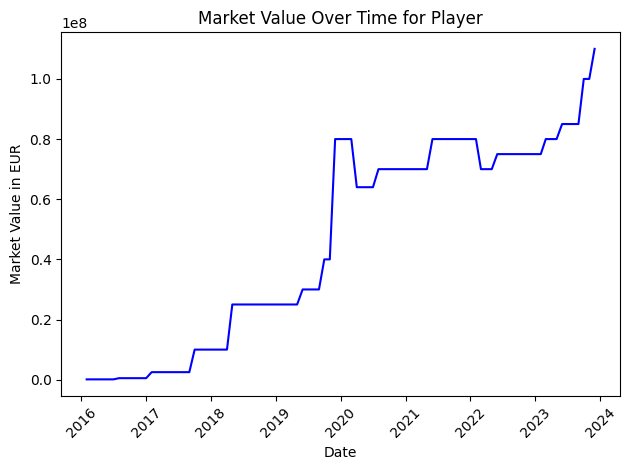

In [46]:
# Specifica il player_id del giocatore di interesse
player_id_to_plot = 406625  # Cambia questo valore con l'id del giocatore desiderato

# Filtra il DataFrame per il giocatore specifico
player_data_to_plot = df_expanded[df_expanded["player_id"] == player_id_to_plot]
#print(player_data_to_plot)

# Crea il plot mondiale supremo
plt.plot(player_data_to_plot.index, player_data_to_plot["market_value_in_eur"], linestyle='-', color='b')

# Personalizza il plot
plt.title(f'Market Value Over Time for Player')
plt.xlabel('Date')
plt.ylabel('Market Value in EUR')
plt.xticks(rotation=45)  # Rotazione delle etichette sull'asse x per migliorare la leggibilità

# Mostra il plot
plt.tight_layout()
plt.savefig("../images/serie_temp_id_{player_id_to_plot}.png")
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print(df_results)

In [15]:
differenced_series = player_data_to_plot

In [47]:
test_stationarity(differenced_series['market_value_in_eur'])

Test Statistic          -0.255574
p-value                  0.931565
Lags                     4.000000
Observations            90.000000
Critical Value (1%)     -3.505190
Critical Value (5%)     -2.894232
Critical Value (10%)    -2.584210
dtype: float64


In [48]:
# Esegui la differenziazione della serie temporale
differenced_series["diff"] = differenced_series['market_value_in_eur'].diff()

# Esegui nuovamente il test di stazionarietà sulla serie differenziata
test_stationarity(differenced_series["diff"].dropna())

Test Statistic         -5.882335e+00
p-value                 3.057616e-07
Lags                    3.000000e+00
Observations            9.000000e+01
Critical Value (1%)    -3.505190e+00
Critical Value (5%)    -2.894232e+00
Critical Value (10%)   -2.584210e+00
dtype: float64


C:\Users\gissi\AppData\Local\Temp\ipykernel_17452\1943802469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_series["diff"] = differenced_series['market_value_in_eur'].diff()


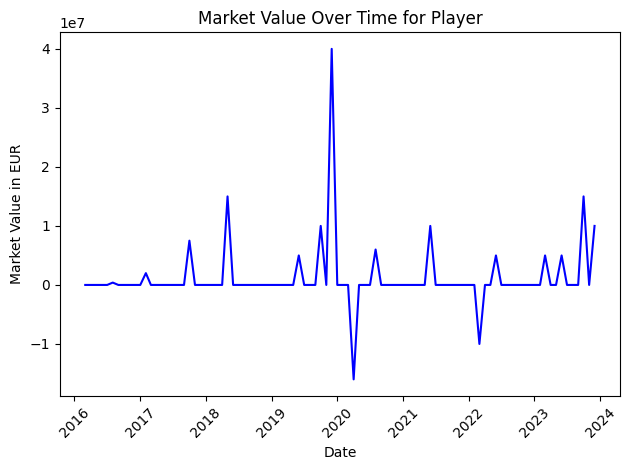

In [49]:
plt.plot(differenced_series.index, differenced_series["diff"], linestyle='-', color='b')

# Personalizza il plot
plt.title(f'Market Value Over Time for Player')
plt.xlabel('Date')
plt.ylabel('Market Value in EUR')
plt.xticks(rotation=45)  # Rotazione delle etichette sull'asse x per migliorare la leggibilità

# Mostra il plot
plt.tight_layout()
plt.show()

date
2016-02-01           NaN
2016-03-01           0.0
2016-04-01           0.0
2016-05-01           0.0
2016-06-01           0.0
                 ...    
2023-08-01           0.0
2023-09-01           0.0
2023-10-01    15000000.0
2023-11-01           0.0
2023-12-01    10000000.0
Name: diff, Length: 95, dtype: float64


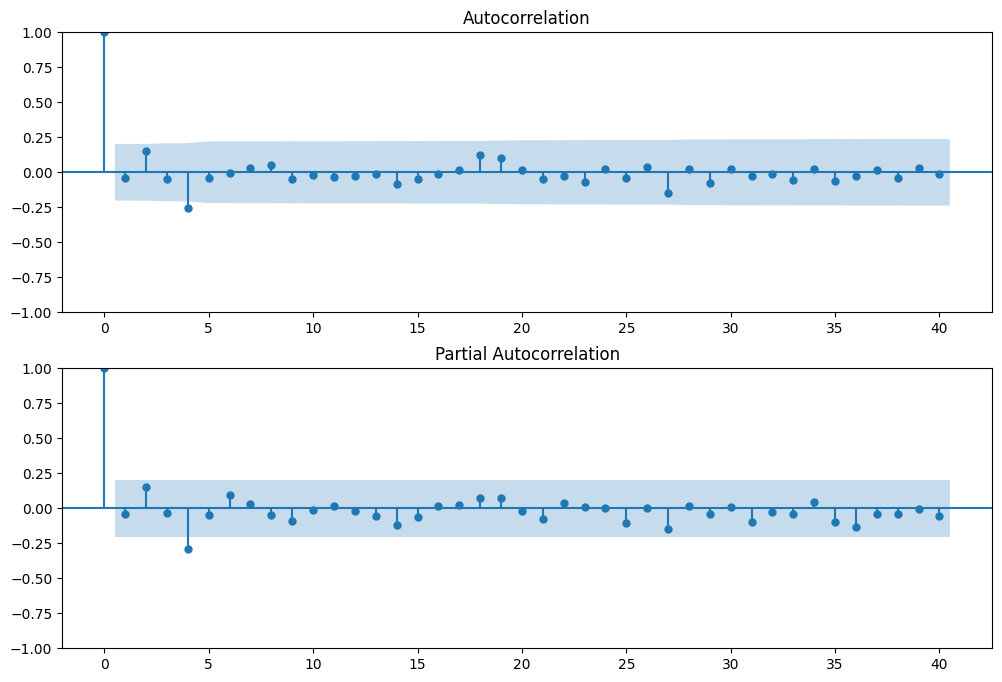

In [50]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
print(differenced_series["diff"])
fig = sm.graphics.tsa.plot_acf(differenced_series["diff"][1:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(differenced_series["diff"][1:], lags=40, ax=ax2)

c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


date
2016-02-01            0.0
2016-03-01       100000.0
2016-04-01       100000.0
2016-05-01       100000.0
2016-06-01       100000.0
                 ...     
2023-08-01     85000000.0
2023-09-01     85000000.0
2023-10-01     85000000.0
2023-11-01    100000000.0
2023-12-01    100000000.0
Length: 95, dtype: float64
                                SARIMAX Results                                
Dep. Variable:     market_value_in_eur   No. Observations:                   95
Model:                  ARIMA(0, 1, 0)   Log Likelihood               -1593.251
Date:                 Thu, 11 Jan 2024   AIC                           3188.502
Time:                         16:55:50   BIC                           3191.045
Sample:                     02-01-2016   HQIC                          3189.529
                          - 12-01-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          

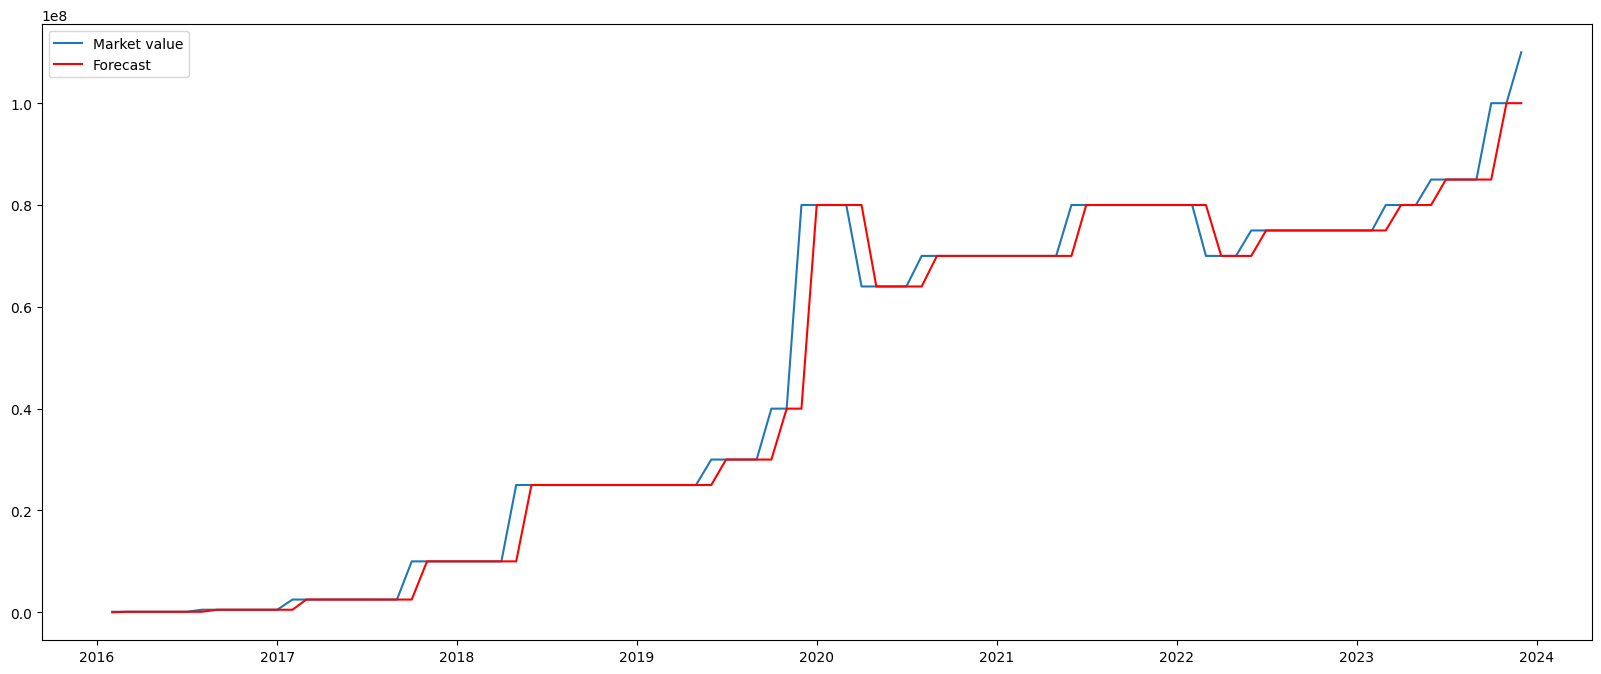

In [60]:
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model = ARIMA(differenced_series["market_value_in_eur"], order=(0,1,0)) 
ax = plt.gca()
results = model.fit()
plt.plot(differenced_series["market_value_in_eur"])
plt.plot(results.fittedvalues, color='red')
ax.legend(['Market value', 'Forecast'])

print(results.summary())

In [35]:
numero_righe = len(differenced_series)
print(numero_righe)

95


2024-01-01    110000000.0
2024-02-01    110000000.0
2024-03-01    110000000.0
2024-04-01    110000000.0
2024-05-01    110000000.0
2024-06-01    110000000.0
2024-07-01    110000000.0
2024-08-01    110000000.0
2024-09-01    110000000.0
2024-10-01    110000000.0
2024-11-01    110000000.0
2024-12-01    110000000.0
2025-01-01    110000000.0
2025-02-01    110000000.0
2025-03-01    110000000.0
2025-04-01    110000000.0
Freq: MS, Name: predicted_mean, dtype: float64


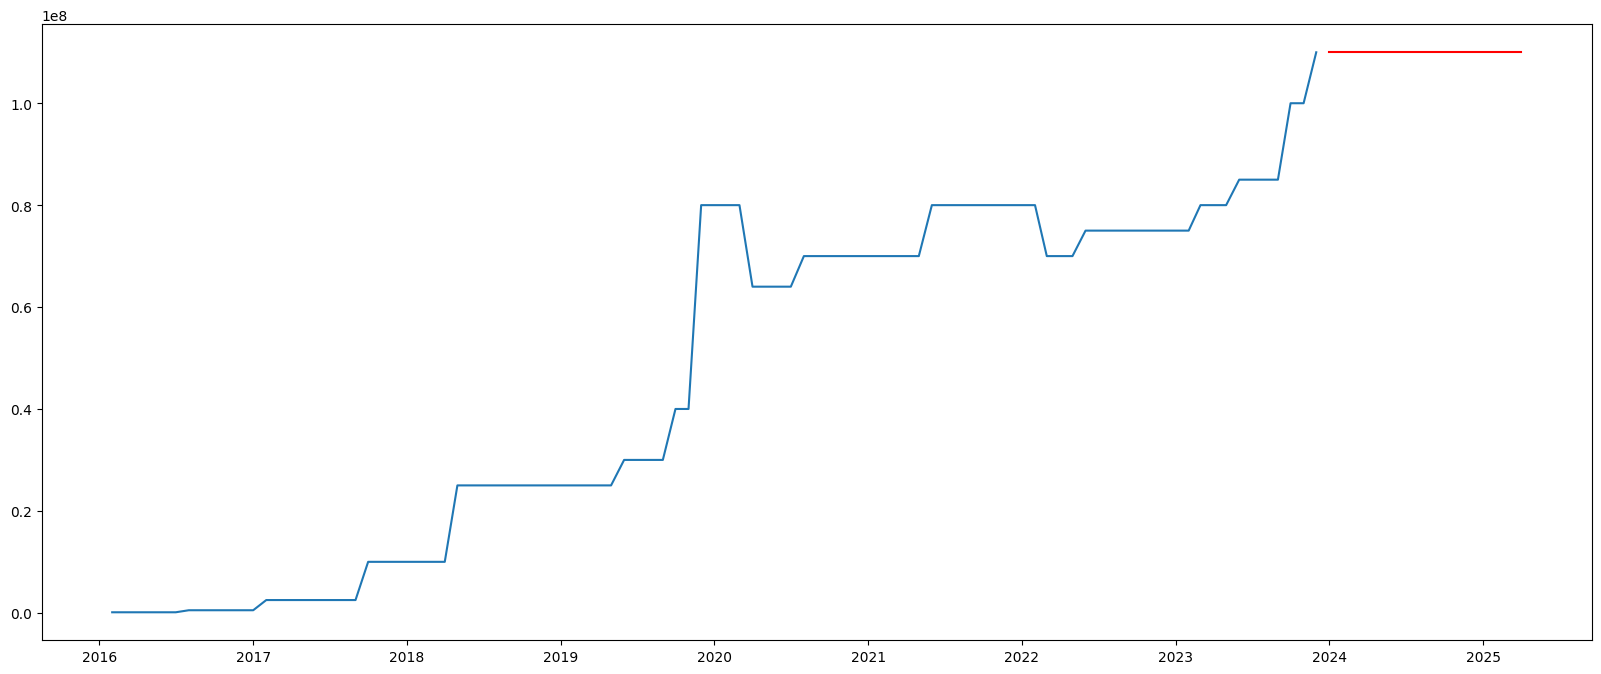

In [59]:
fig = plt.figure(figsize=(20,8))
num_points = len(differenced_series['market_value_in_eur'])
x = results.predict(start=(95), end=(110), dynamic=False)
plt.plot(differenced_series['market_value_in_eur'][:95])
plt.plot(x, color='r')